# Classification tables d'intérêt des pdf

#### Import

In [22]:
# pip install seaborn


  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
%config IPCompleter.greedy = True
%matplotlib inline

In [24]:
dath_path = r'C:\Users\s.doudou\Documents\GEEK\Geeks V2\table-transformer\datasets\csv\table_dataset.csv'
data = pd.read_csv(dath_path, delimiter=';')
df = data[['text', 'interest_table']]

df.head()

,text,interest_table
0,MARK NO. QTY SIZE SERIES FACING TYPE MIN. HOLE...,1
1,CONFIDENTIAL THIS DRAWING IS THE SOLE PROPERTY...,0
2,TAM. RVVess ff UVRVoOLU Part Numbers FIND y...,1
3,cen a a a ec ll Ml A aca sia seca Part Numbe...,1
4,Part Numbers DESCRIPTION | QTY|(*) spare pars...,1


### Proportion des valeurs

In [25]:
df['interest_table'].value_counts()

interest_table
0    601
1    147
Name: count, dtype: int64

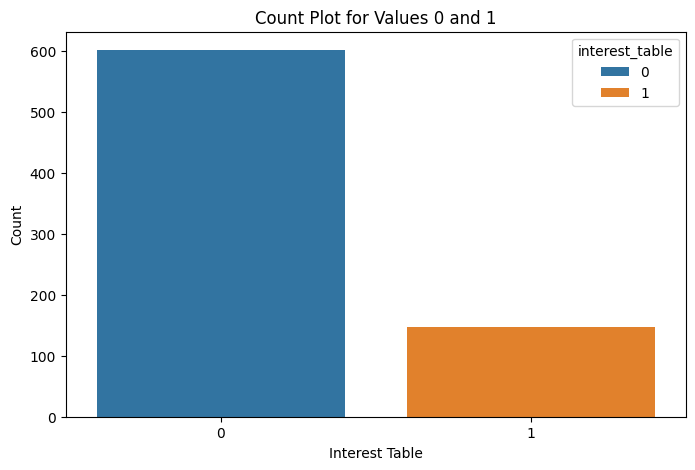

In [29]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='interest_table', hue='interest_table')

# Set labels and title
plt.xlabel('Interest Table')
plt.ylabel('Count')
plt.title('Count Plot for Values 0 and 1')

# Show the plot
plt.show()

## Data cleaning

In [30]:
# nltk.download('stopwords')
# nltk.download('popular')
# pip install scikit-learn

In [31]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import pandas as pd

def cleaning_pdf_interest(df, col_name):
    porter = PorterStemmer()
    stop_words = set(stopwords.words())

    def clean_text(text):
        text = str(text)
        text = text.lower()
        text = re.sub('(<.*?>)|(\n)|([^\w\s\.\,])|([_])|([.])|([,])|(\s\s+)|([ا-ي])', '', text)
        cleaned_text = ' '.join([porter.stem(i) for i in word_tokenize(text) if i not in stop_words])
        return cleaned_text

    cleaned_column = df[col_name].apply(clean_text)
    
    return cleaned_column


* Chaque mot est transformer en miniscule avec lower.
* on utilise une expression reguliere pour remplacer  : les balise html, les retour a la ligne, les caractere spéciaux qui ne sont pas des point ou des virgule  (par exemple, !, ?, :) ,les underscore, les points, les virgules, les espace multiple et les mots non anglais par un espace vide
* chaque mot qui n'est pas un stop_word (and, or, but, etc) est tokenizer et on retour sa basse (ex : terreste devient terre)


In [32]:
df['text'] = cleaning_pdf_interest(df,'text')

In [33]:
df['text'][:5]

0    mark qti size seri face type hole id neckservi...
1    confidenti draw sole properti peerlessmfg comp...
2    tam rvvess ff uvrvoolupart numbersfindy descri...
3    cen ec ml acasia secapart numbersfindy descrip...
4    part numbersdescript qti spare par recommended...
Name: text, dtype: object

## Split train and test

In [34]:
# pip install scikit-learn

In [39]:
from sklearn.model_selection import train_test_split
X = df['text'].tolist()
y = df['interest_table'].tolist()
y = [int(x) for x in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [40]:
# pip install scikit-learn

### Vectorisation 

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(stop_words='english', max_features=None, max_df=0.5, min_df=2, ngram_range=(1,1))

X_train = tfidf_vector.fit_transform(X_train)
X_test = tfidf_vector.transform(X_test)

## Model

## 1- Logistic regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


In [43]:
lr = LogisticRegression(random_state=42)
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       181
           1       1.00      0.43      0.60        44

    accuracy                           0.89       225
   macro avg       0.94      0.72      0.77       225
weighted avg       0.90      0.89      0.87       225



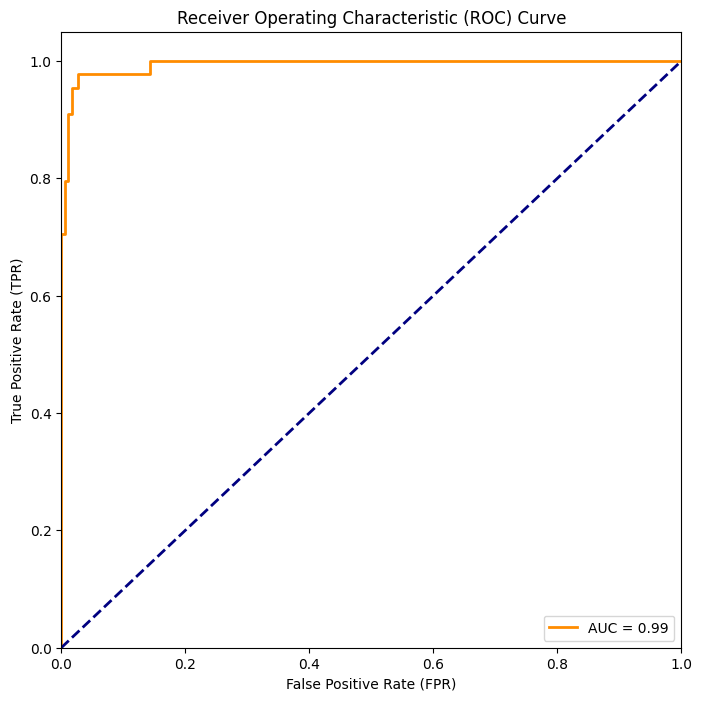

In [44]:
y_prob = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [45]:
coef_abs = abs(lr.coef_[0]).tolist()
feature_scores = pd.Series(coef_abs).sort_values(ascending=False)
lr_best_index = feature_scores[:10].index
for index in lr_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


 feature : 2055 : {'pospart'}
 feature : 213 : {'135'}
 feature : 1995 : {'pagina'}
 feature : 2002 : {'pc'}
 feature : 1642 : {'gener'}
 feature : 1968 : {'number'}
 feature : 1193 : {'approv'}
 feature : 1544 : {'engineproduct'}
 feature : 2045 : {'po'}
 feature : 1385 : {'cpage'}


## 2-Random forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rf = RandomForestClassifier(min_samples_split=5 ,max_depth=10, random_state=42)
rf = rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       181
           1       1.00      0.68      0.81        44

    accuracy                           0.94       225
   macro avg       0.96      0.84      0.89       225
weighted avg       0.94      0.94      0.93       225



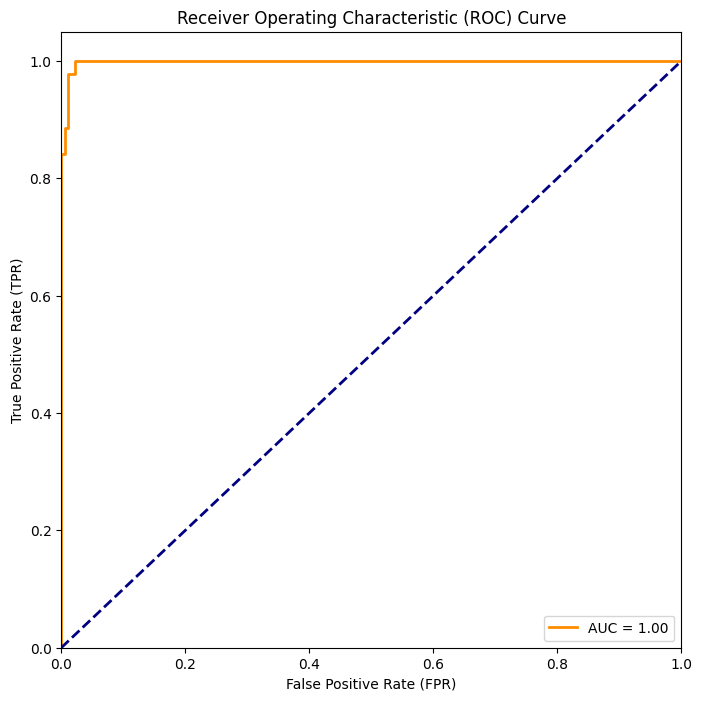

In [49]:
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [50]:
feature_scores = pd.Series(rf.feature_importances_).sort_values(ascending=False)
rf_best_index = feature_scores[:10].index
for index in rf_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


 feature : 2055 : {'pospart'}
 feature : 1872 : {'machin'}
 feature : 1486 : {'dwg'}
 feature : 1699 : {'id'}
 feature : 2058 : {'pqr'}
 feature : 1642 : {'gener'}
 feature : 2350 : {'spteeee'}
 feature : 1378 : {'copyright'}
 feature : 2044 : {'pn'}
 feature : 14 : {'001'}


## 3-LinearSV

In [51]:
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=42)
svm = svm.fit(X_train, y_train)
y_pred3 = svm.predict(X_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       181
           1       1.00      0.77      0.87        44

    accuracy                           0.96       225
   macro avg       0.97      0.89      0.92       225
weighted avg       0.96      0.96      0.95       225



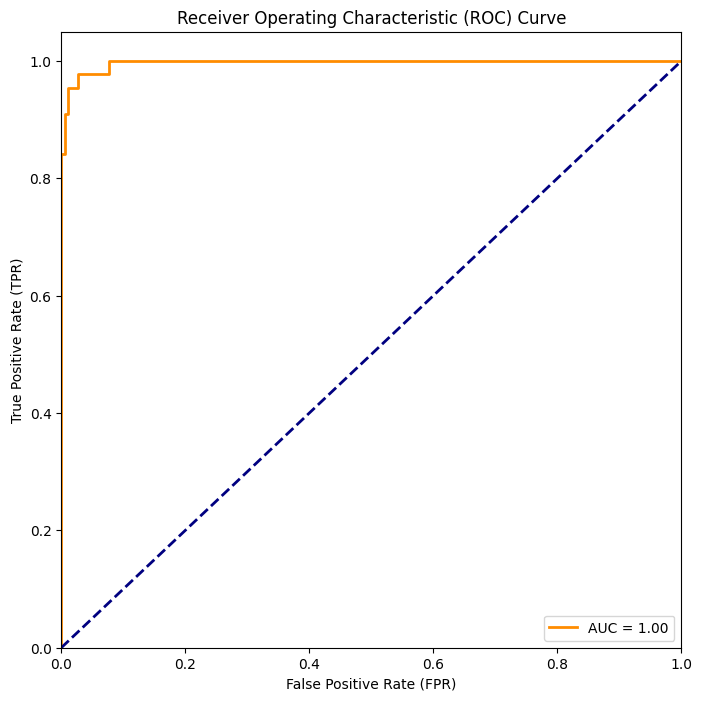

In [52]:
y_scores = svm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [53]:
coef_abs = abs(svm.coef_[0]).tolist()
feature_scores = pd.Series(coef_abs).sort_values(ascending=False)
svm_best_index = feature_scores[:10].index


for index in svm_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


 feature : 2055 : {'pospart'}
 feature : 213 : {'135'}
 feature : 2106 : {'radiat'}
 feature : 1642 : {'gener'}
 feature : 1936 : {'nan'}
 feature : 2045 : {'po'}
 feature : 1995 : {'pagina'}
 feature : 1981 : {'ooo'}
 feature : 2301 : {'serial'}
 feature : 1143 : {'aaa'}


## sauvegarde des models 

In [54]:
import os
os.listdir()

['.git',
 '.gitignore',
 '.idea',
 'config',
 'datasets',
 'exttraction_for_inference.py',
 'merge_text_and_scan_dataset.py',
 'myenv',
 'npl_data_classifaction.ipynb',
 'pdf_scan_table_pages_extraction.py',
 'pdf_text_data_extraction.py',
 'preprocess',
 'Readme.md',
 'requirements.txt',
 'table-transformer',
 'table_detector.py',
 'test_datasets',
 'utils',
 '__pycache__']

In [66]:
# import joblib
# os.makedirs('table_classifier_models')
# joblib.dump(lr, 'table_classifier_models/lr_model.pk')
# joblib.dump(rf, 'table_classifier_models/rf_model.pkl')
# joblib.dump(svm, 'table_classifier_models/svm_model.pkl')


In [67]:
lr_model = joblib.load('./table_classifier_models/lr_model.pk')
lr_model = joblib.load('./table_classifier_models/rf_model.pkl')
svm_model = joblib.load('./table_classifier_models/svm_model.pkl')

# Test sur les données non annotées

In [68]:
# from exttraction_for_inference import extract_data

In [75]:
test_path = r'C:\Users\s.doudou\Documents\GEEK\Geeks V2\table-transformer\test_datasets\csv\table_dataset.csv'


test_data = pd.read_csv(test_path, delimiter=";")
test_data['text'] = cleaning_pdf_interest(test_data, 'text')
y_test_data = tfidf_vector.transform(test_data['text'].tolist())

In [76]:
pred = lr_model.predict(y_test_data)

In [77]:
pred

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [79]:
test_data['is_interest'] = pred

In [81]:
os.makedirs('Prediction')

In [82]:
test_data.to_csv('Prediction/lr_prediction.csv')

In [83]:
test_data

,Unnamed: 0,path,page,is_scan,text,is_interest
0,0,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,0,False,item revis equip instrument tag number manufac...,1
1,1,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,1,False,item revis equip instrument tag number manufac...,0
2,2,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,2,False,item revis equip instrument tag number manufac...,1
3,3,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,3,False,itwm revis equip instrument tag number manufac...,1
4,4,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,4,False,itwm revis equip instrument tag number manufac...,1
...,...,...,...,...,...,...
719,719,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,5,True,refno partno sapno spare part list typ rvp4 pr...,0
720,720,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,0,False,d103247xus2 instal guid englishmarch 2015 type...,0
721,721,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,1,False,2 type mr108 accumul prevent suchinjuri damag ...,0
722,722,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,2,False,3 type mr108 part list keydescript 1valv bodi ...,1


In [84]:
test_data.path[0]

'C:\\Users\\jeanm\\Downloads\\DOC DATA CHALLENGE\\DOC DATA CHELLENGE\\SPARE_DOCUMENT\\ASCEA-10-Q24048-0002_02 - CE WHP - FST- Instrument Air Package - Operational Spare Parts List For Instrument Air Compressor & Dryer Package (ASCEA-A-5451-5452).pdf'

In [90]:
path1 = r'C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DOC DATA CHELLENGE\SPARE_DOCUMENT'
path2 = r'C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DOCUMENT'
test_data['path'] =test_data.path.apply(lambda x: x.replace(path1, path2))

In [91]:
test_data

,Unnamed: 0,path,page,is_scan,text,is_interest
0,0,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,0,False,item revis equip instrument tag number manufac...,1
1,1,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,1,False,item revis equip instrument tag number manufac...,0
2,2,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,2,False,item revis equip instrument tag number manufac...,1
3,3,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,3,False,itwm revis equip instrument tag number manufac...,1
4,4,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,4,False,itwm revis equip instrument tag number manufac...,1
...,...,...,...,...,...,...
719,719,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,5,True,refno partno sapno spare part list typ rvp4 pr...,0
720,720,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,0,False,d103247xus2 instal guid englishmarch 2015 type...,0
721,721,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,1,False,2 type mr108 accumul prevent suchinjuri damag ...,0
722,722,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,2,False,3 type mr108 part list keydescript 1valv bodi ...,1


## document scannée et d'interer

In [101]:
test_data[(test_data.is_scan == True) & (test_data.is_interest ==1)]

,Unnamed: 0,path,page,is_scan,text,is_interest
43,43,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,2,True,typic eex eex motor 1 2 3 4 5 6 7 8 9 10 11 12...,1
63,63,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,1,True,item qtyus ontag no112fansb5501111122dos pumps...,1
72,72,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,1,True,iproject document no2 year oper sparesnsv0705g...,1
120,120,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,0,True,2 32 item w m3 7000 4200 4000 112 7000 4200 40...,1
121,121,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,1,True,3 32 01a 25 item po qti 001 1 pressur nozzl au...,1
122,122,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,2,True,4 32 01b 25 item po qti 001 1 pack list eng pk...,1
123,123,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,3,True,5 32 02ab 25 item po qti 001 1 002 1 003 4 004...,1
124,124,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,4,True,6 32 03a 25 item po qti 001 02 1 wooden box pn...,1
125,125,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,5,True,7 32 03b 25 item po qti 001 02 1 wooden box pn...,1
126,126,C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DO...,6,True,8 32 04a 25 item po qti 001 05 1 wooden box pn...,1


In [102]:
# pip install pdfplumber

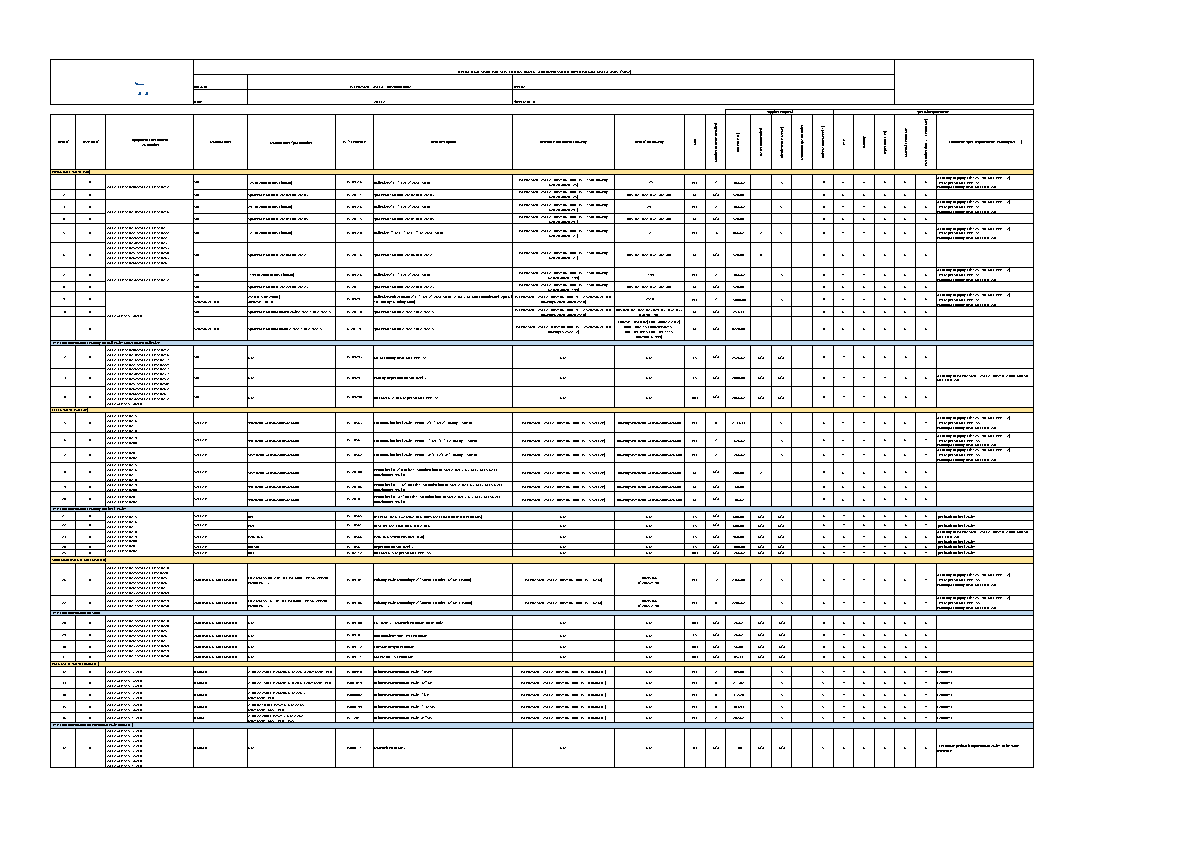

In [97]:
import pdfplumber
page_number = 0
pdf_path = test_data['path'][0]

with pdfplumber.open(pdf_path) as pdf:
    pages = pdf.pages
    page = pages[page_number]
page.to_image()


## Table d'interret issue d'u tableau scannée

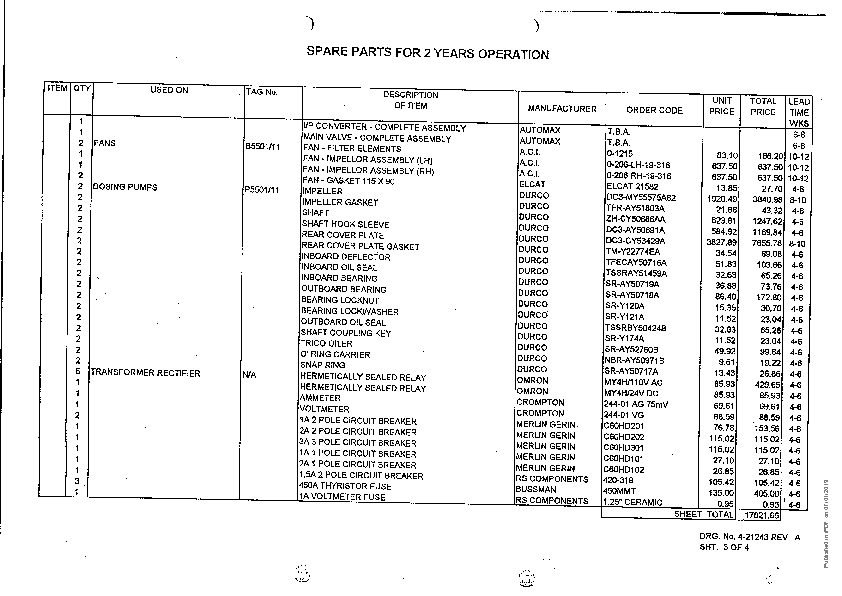

In [103]:
page_number = 1
pdf_path = test_data['path'][63]

with pdfplumber.open(pdf_path) as pdf:
    pages = pdf.pages
    page = pages[page_number]
page.to_image()